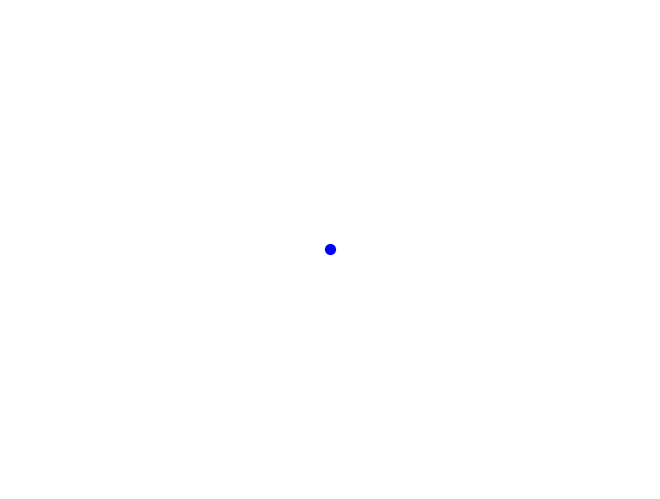

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 15 16:51:20 2024

@author: JNI
"""

import numpy as np
from pyomo.environ import *
import highspy as hp
import pandas as pd
import plotly
import plotly.express as px
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import time


"""
Region class:
~~~~~~~~~~~~
    
    Class objects are regions, which have a natural tree-structure. Each region
    can have a parent region and child regions (subregions), a data object, and 
    a set of hubs.
  
    class variables:
    ~~~~~~~~~~~~  
    
    self.name = str of the regions name (from data file input)
    self.parent = pointer to the parent region object
    self.childrem = dict of subregions, with name:object format
    self.data = data object, which should contain region-specific parameters
    self.grid = the grid the region lies in (inherited from parent region)
    self.depth = distance from root of tree
    
    class methods:
    ~~~~~~~~~~~~  
    
    display_children - prints a list of subregions
    display_hubs - prints a list of hubs in the region
    update_parent - changes the parent region (used in aggregation)
    create_subregion - creates a subregion with given name and data
    add_subregion - takes an existing region as an arg and assigns it as a subregion
    remove_subregion - removes a subregion from list of subregions
    add_hub - adds an existing hub to region hubs
    remove_hub - removes a hub from region hubs
    delete - deletes the region. hubs and subregions are reassigned to parent
    absorb_subregions -  aggregates subregion data into region's data, then deletes them, 
                         inherits their subregions and hubs
    absorb_subregions_deep - recursively runs absorb_subregions on subregions, 
                             their subregions etc so that region is the bottom level
    update_data - replaces data object with arg
    aggregate_subregion_data - takes all subregions, and aggregates their data
                               based on whether they are summable or meanable 
    get_data - pass the name of a parameter in data as arg, and receive the value.
    
"""


class Region:
    
    def __init__(self, name, grid = None, kind = None, data = None, parent=None):
        
        self.name = name
        self.parent = parent
        self.children = {}
        self.hubs = {}
        self.data = data
        
        if self.parent != None: 
            self.depth = self.parent.depth + 1 
            self.grid = parent.grid
            
        else: 
            self.depth = 0
            self.grid = grid
 

        
    def display_children(self):
        for child in self.children.values():
            print(child.name, child.depth)
            child.display_children()
       
        
    def display_hubs(self):
        
        for hub in self.hubs.values():
            print(hub.name)
        
    def update_parent(self, new_parent):
        
        if self.parent != None:
            del self.parent.children[self.name]
            self.parent = new_parent
            self.parent.add_subregion(self)
            self.depth = new_parent.depth + 1
            
        else: 
            self.parent = new_parent
            self.parent.add_subregion(self)
    
    def create_subregion(self,name, data = None):
        
        self.grid.create_region(name,self,data)

    def add_subregion(self,subregion):
        
        self.children.update({subregion.name:subregion})
        
    def remove_subregion(self,subregion):
        self.children.pop(subregion.name)       
    
    def add_hub(self, hub):
        self.hubs.update({hub.name:hub})
        
    def remove_hub(self,hub):
        del self.hubs[hub.name]
        
    def delete(self):
        
        for hub in self.hubs.values():
            hub.change_region(self.parent)
            
        for child in list(self.children.values()):
            child.update_parent(self.parent)
            self.parent.add_subregion(child)
        
        if self.name in self.parent.children.keys():
            self.parent.remove_subregion(self)
        
        
        
    def absorb_subregions(self):
        
        subregions = list(self.children.values())
        
        if self.data is None: self.aggregate_subregion_data(subregions)
        
        
        for subregion in subregions:
            self.grid.delete(subregion)
            
        del subregions
    
    def absorb_subregions_deep(self):
        
        subregions = list(self.children.values())
        #print([subregion.name for subregion in subregions])
        
        for subregion in subregions:
            #print(subregion.name)
            
            subregion.absorb_subregions_deep()
            
            print("deleting: ", subregion.name)
            
            if self.data is None: self.aggregate_subregion_data(subregions)
            self.grid.delete(subregion)
            
        del subregions
    
    def update_data(self,df):
        self.data = df

    def aggregate_subregion_data(self,subregions):
        
        temp_child_data = pd.concat([region.data for region in subregions], axis = 1).transpose()
        #print(temp_child_data)
        new_data = pd.DataFrame(columns= self.grid.data.summable['region'] + self.grid.data.meanable['region'])
        
        for column in temp_child_data.columns:
            if column in self.grid.data.summable['region']: new_data[column] = [temp_child_data[column].sum()]
            if column in self.grid.data.meanable['region']: new_data[column] = [temp_child_data[column].mean()]
        
        self.update_data(new_data.squeeze())
        
    def get_data(self,quantity):
        
        if self.data is None: return 0
        else: return self.data[quantity]
             
        
'''
HUB CLASS
~~~~~~~~~

class objects are individual hubs, which are fundamental units of production in
the model. Hubs belong to regions, and connect to each other with transportation
arcs.

    class variables:
    ~~~~~~~~~~~~~~~
    
    name - str name of hub (from input data or aggregated)
    region - region located in
    data - data object that stores hub-specific parameters
    outbound - dict of arcs outbound from hub, with destination hub name:destination hub object format
    inbound - dict of arcs inbound to hub, with origin hub name: origin hub object format
    x,y - location coordinates (will deprecate)
    
    class methods:
    ~~~~~~~~~~~~~
    
    change_region - region arg becomes hub's region and hub is added to args hublist
    display_outbound - print outbound arcs
    display_inbound - print inbound arcs
    add_outbound - add arc arg as an outbound arc
    add_inbound - add arc arg as an inbound arc
    remove_outbound - remove an outbound arc
    remove_inbound - remove an inbound arc
    get_data - pass the name of a parameter in data as arg, and receive the value.
    cost - temp cost function, to be deprecated
'''
        
class Hub:
    
    
    
    def __init__(self,name,region,data=None):
        
        self.name = name
        self.region = region
        self.data = data.fillna(0)
        
        # outbound and inbound dictionaries mapping names of hubs to the arc objects
        self.outbound = {}
        self.inbound = {}
        
        self.x = data.iloc[0]['x']
        self.y = data.iloc[0]['y']

    
    def change_region(self,new_region):
        self.region = new_region
        new_region.add_hub(self)
        
    
    def display_outbound(self):
        for arc in self.outbound.values():
            print("name:",arc.origin.name,"capacity:",arc.capacity)
               
     
    '''
    Add and remove arc functions
    
    only modifies itself
    '''    
    def add_outbound(self,arc):
        
        self.outbound[arc.destination.name] = arc
    
    def add_inbound(self,arc):
        
        self.inbound[arc.origin.name] = arc
            
    def remove_outbound(self,arc):
        
        del self.outbound[arc.destination.name]
    
    def remove_inbound(self,arc):
        
        del self.inbound[arc.origin.name]
    
    
    def get_data(self,quantity):
        
        return self.data.iloc[0][quantity]
        
    def cost(self,technology,year):
        
        
        
        
        if technology == 'PEM': return self.region.data['electricity_cost']*45
        elif technology == 'SMR': return self.region.data['gas_cost'] 
        else: return 0 
        
        
'''
TRANSPORTATION ARC CLASS
~~~~~~~~~~~~~~~~~~~~~~~~
    
    objects in this class represent individual transportation arcs. An arc can
    exist with zero capacity, so they only represent *possible* arcs.
    
    class variables:
    ~~~~~~~~~~~~~~~
    
    name - the name used by the registry. Unlike regions and hubs, arc names are
           fully determined. They are tuples of origin hub name and dest hub name.
    origin - pointer to origin hub object
    destination - pointer to destination hub object
    capacity - base capacity
    cost - generic cost parameter (to be deprecated)
    
    class methods:
    ~~~~~~~~~~~~~
    
    change_origin - changes the origin hub and name to reflect that
    chage_destination - changes the destination hub and name to reflect that
    disconnect - removes itself from the inbound and outbound hubs' arc lists.
    
'''
        
        
        
        
        
class TransportationArc:
    
    
    def __init__(self,origin, destination, capacity,cost = 0):
        
        
        self.name = (origin.name,destination.name)
        self.origin = origin
        self.destination = destination
        self.capacity = capacity
        self.cost = cost
        
    def change_origin(self,new_origin):
        
        self.name = (new_origin.name,self.name[1])
        self.origin = new_origin
    
    def change_destination(self,new_destination):
        self.name = (self.name[0],new_destination.name)
        self.destination = new_destination

    def disconnect(self):
        
        self.origin.remove_outbound(self)
        self.destination.remove_inbound(self)
        
     
        
'''
REGISTRY CLASS
~~~~~~~~~~~~~~
     
    This class is the central registry of all objects in a grid. It preserves them 
    in dicts of object-name:object so that they can be looked up by name.
    it also should serve as a place to save data in different configurations for
    faster parsing - for example, depth is a dict that organizes regions according to
    their depth in the region nesting tree.
    
    class variables:
    ~~~~~~~~~~~~~~~
    
    regions - dict of region name:region object
    hubs - dict of hub name:hub object
    arcs - dict of arc name:arc object
    depth - dict of ints and lists of regions with int n:list of regions at that depth
    max_depth - the max depth in the tree
    
    
    class methods:
    ~~~~~~~~~~~~~
     
    add - generic method to add something to the registry. Depending on the type
          thing, it adds it to the appropriate variable and adjusts others as necessary
    remove - generic method to remove something from the registry. Depending on the 
             type of thing, it removes it from the appropriate variable and adjusts
             others as necessary.
    update_levels - updates the level counts (such as when you aggregate and a region
                    changes level)
    
    
'''
        
class Registry:
    
    def __init__(self):
        self.regions = {}
        self.depth = {i:[] for i in range(10)}
        self.hubs = {}
        self.arcs = {}
        self.max_depth = 0
        
        
    def add(self,thing):
        
        if type(thing) == Hub:
            self.hubs[thing.name] = thing
            return thing
        elif type(thing) == TransportationArc:
            self.arcs[thing.name] = thing
            return thing
        elif type(thing) == Region:
            self.regions[thing.name] = thing
            self.depth[thing.depth].append(thing.name)
            if thing.depth > self.max_depth: self.max_depth = thing.depth
            return thing
        
    def remove(self,thing):
        
        if type(thing) == Hub:
            del self.hubs[thing.name]
        elif type(thing) == Region:
            #self.depth[thing.depth] = self.depth[thing.depth].remove(thing.name)
            del self.regions[thing.name]
            
        elif type(thing) == TransportationArc:
            del self.arcs[thing.name]
            
    def update_levels(self):
        
        self.depth = {i:[] for i in range(10)}
        for region in self.regions.values():
            self.depth[region.depth].append(region.name)
        pass
        
'''
GRID CLASS
~~~~~~~~~~~

    This is the central class that binds all the other classes together. No class
    instance exists in a reference that isn't fundamentally contained in a grid.
    The grid is used to instantiate a model, read data, create the regionality
    and hub / arc network within that regionality, assign data to objects and more.
    
    notably, the grid is used to coordinate internal methods in various classes to 
    make sure that their combined actions keep the model consistent and accomplish
    the desired task.
    
    class variables:
    ~~~~~~~~~~~~~~~
    
    data = this is a data object 
    
    class methods:
    ~~~~~~~~~~~~~
    
    
'''        
class Grid:
    
    def __init__(self, data = None):
        
        if data != None:
            self.data = data
            
            
            
    def visualize(self):
        
        
        G = nx.DiGraph()
        positions = {}
        for hub in self.registry.hubs.values():
            if hub.region.depth == 1:
                color = 'green'
                size = 100
            elif hub.region.depth == 2: 
                color = 'red'
                size = 50
                
            else: 
                color = 'blue'
                size = 30
                
            G.add_node(hub.name, pos = (hub.x,hub.y), color = color)
            positions[hub.name] = (hub.x,hub.y)
        edges = [arc for arc in self.registry.arcs.keys()]
        
        G.add_edges_from(edges)

        node_colors = [G.nodes[data]['color'] for data in G.nodes()]

        nx.draw(G, positions, with_labels = False, node_size = 50, node_color = node_colors)
        plt.show()

    """
    Creation methods for region, hub, and arc.
    
    All classes should refer to these methods when creating instances so that everything
    is centralized. The methods will have return values so they can also be accessed during creation
    within their class. In some cases, the natural procedure should be to initiate the creation within
    another instance of the class so that the return value can be taken advantage of.
    
    
    """


    def create_region(self,name,parent = None, data = None):
        
        if parent == None:         
            return self.registry.add_region(Region(name,parent = parent,grid = self,data = data))
        else:
            parent.add_subregion((self.registry.add(Region(name,parent = parent,grid = self,data = data))))
            
    def create_arc(self,origin,destination,capacity, cost = 0):
        
        self.registry.add(TransportationArc(origin, destination, capacity,cost))
        origin.add_outbound(self.registry.arcs[(origin.name,destination.name)])
        destination.add_inbound(self.registry.arcs[(origin.name,destination.name)])
    
    def create_hub(self, name, region, data = None):
        
        
        region.add_hub(self.registry.add(Hub(name,region,data)))
        
    '''
    delete function (works on arcs, hubs, and regions)
    '''    
    
    def delete(self,thing):
        
        if type(thing) == Region:
            
            thing.delete()
            self.registry.remove(thing)
            
        if type(thing) == Hub:
            
            for arc in list(thing.outbound.values()):
                self.delete(arc)   
            for arc in list(thing.inbound.values()):
                self.delete(arc)
            
            thing.region.remove_hub(thing)
            self.registry.remove(thing)
            
        if type(thing) == TransportationArc:
            
            thing.disconnect()
            self.registry.remove(thing)
    
    
    def build_grid(self):
        
        self.registry = Registry()
        self.world = Region('world', grid = self, data = self.data.regions)
        
        
        self.recursive_region_generation(self.data.regions,self.world)
        self.load_hubs()
        self.arc_generation(self.data.arcs)
        
        self.visualize()
        
    def recursive_region_generation(self,df, parent):

        if df.columns[0] == 'data':
            for index, row in df.iterrows():
                #print(row[1:])
                parent.update_data(row[1:])
                
                '''
                if type(row.hub) == str: 
                    self.create_hub(row.hub, parent,self.data.hubs.loc[self.data.hubs.hub == row.hub][self.data.hubs.columns[1:]])
                    parent.update_data(df[df.columns[1:]])
                '''
        else: 
            
            
            for region in df.iloc[:,0].unique():
                if type(region) == str and region != 'None':
                    #print(df.columns[0]+':',region)
                    parent.create_subregion(region)
                    self.recursive_region_generation(df[df[df.columns[0]] == region][df.columns[1:]], parent.children[region])
                elif region == 'None':
                    
                    self.recursive_region_generation(df[df[df.columns[0]].isna()][df.columns[1:]], parent)
                
                else:
                    
                    self.recursive_region_generation(df[df[df.columns[0]].isna()][df.columns[1:]], parent)


    def arc_generation(self,df):
        
        for index, row in df.iterrows():
            
            self.create_arc(self.registry.hubs[row.origin],self.registry.hubs[row.destination],row['capacity'])
            #self.registry.add(TransportationArc(self.registry.hubs[row.origin],self.registry.hubs[row.destination],row['capacity']))
            #self.registry.hubs[row.origin].add_outbound(self.registry.arcs[(row.origin,row.destination)])
            #self.registry.hubs[row.destination].add_inbound(self.registry.arcs[(row.origin,row.destination)])
    
    def connect_subregions(self):
        
        for hub in self.registry.hubs.values():
            
            if hub.region.children == {}:
                
                for parent_hub in hub.region.parent.hubs.values():
                    
                    self.create_arc(hub, parent_hub, 10000000)
    

    def load_hubs(self):
        
        for index, row in self.data.hubs.iterrows():
            
            #print(row['hub'], row['region'])
            #print(row[2:], type(row[2:]))
            self.create_hub(row['hub'], grid.registry.regions[row['region']], data = pd.DataFrame(row[2:]).transpose().reset_index())
            
            
    
    def aggregate_hubs(self,hublist,region):
        
        
        
        temp_hub_data = pd.concat([hub.data for hub in hublist])  
        new_data = pd.DataFrame(columns= self.data.summable['hub'] + self.data.meanable['hub'])
        
        for column in temp_hub_data.columns:
            if column in self.data.summable['hub']: new_data[column] = [temp_hub_data[column].sum()]
            if column in self.data.meanable['hub']: new_data[column] = [temp_hub_data[column].mean()]
        
        name = '_'.join([hub.name for hub in hublist])
        self.create_hub(name,region,new_data)
        
        inbound = {}
        outbound = {}
        
        for hub in hublist:
            for arc in hub.inbound.values():
                if arc.origin not in hublist:
                    if arc.origin.name not in inbound.keys(): inbound[arc.origin.name] = [arc]
                    else: inbound[arc.origin.name].append(arc)
            for arc in hub.outbound.values():
                if arc.destination not in hublist:
                    if arc.destination.name not in outbound.keys(): outbound[arc.destination.name] = [arc]
                    else: outbound[arc.destination.name].append(arc)
            
        for origin in list(inbound.keys()):
            self.combine_arcs(inbound[origin],self.registry.hubs[origin],self.registry.hubs[name])
        for destination in list(outbound.keys()):
            self.combine_arcs(outbound[destination],self.registry.hubs[name],self.registry.hubs[destination])
        
        del inbound
        del outbound
        
        for hub in hublist:
            self.delete(hub)
        
        del hublist                        
            
    def combine_arcs(self,arclist,origin,destination):
            
        capacity = sum([arc.capacity for arc in arclist])
        cost = sum([arc.cost*arc.capacity for arc in arclist])/capacity
            
        self.create_arc(origin, destination, capacity,cost)
        
        for arc in arclist: self.delete(arc)
                
    def write_data(self):
        
        hublist = [hub for hub in list(self.registry.hubs.values())]
        hubdata = pd.concat([pd.DataFrame({'hub':[hub.name for hub in hublist]}),pd.concat([hub.data for hub in hublist]).reset_index()], axis = 1)
        hubdata.to_csv('saveddata.csv', index = False)
        
        regionlist = [region for region in list(self.registry.regions.values()) if not region.data is None]
        regiondata = pd.concat(  [pd.DataFrame(  {'region':[region.name for region in regionlist]} ),pd.concat([region.data for region in regionlist], axis = 1).transpose().reset_index()] , axis = 1)
        regiondata = regiondata[['region'] + self.data.summable['region'] + self.data.meanable['region']]
        regiondata.to_csv('regiondatasave.csv', index= False)
        
        arclist = [arc for arc in list(self.registry.arcs.values())]
        arcdata = pd.DataFrame({'origin':[arc.origin.name for arc in arclist], 'destination': [arc.destination.name for arc in arclist], 'capacity': [arc.capacity for arc in arclist], 'cost': [arc.cost for arc in arclist]})
        arcdata.to_csv('arcdatasave.csv',index = False)
        
    
    def collapse(self,region_name):
        
        self.registry.regions[region_name].absorb_subregions_deep()
        self.aggregate_hubs(list(self.registry.regions[region_name].hubs.values()),self.registry.regions[region_name])
        self.registry.update_levels()
        self.visualize()        
    

    def build_model(self, mode = 'standard'):
        
        self.model = Model(self, mode)
        
    def test(self):
        
        start = time.time()
        
        self.build_model()
        self.model.start_build()
        self.model.solve(self.model.m)

        end = time.time()
        
        print(end - start)
        
    def collapse_level(self,level):
        for region in self.registry.depth[level]: self.collapse(region)


class Data:
    
    def __init__(self):
        
        self.regions = pd.read_csv('regions_single_test.csv', index_col = False)
        self.hubs = pd.read_csv('hubs_single_region.csv', index_col = False)
        self.arcs = pd.read_csv('transportation_arcs_single_region.csv', index_col = False)
        
        #self.regions = pd.read_csv('regions.csv', index_col = False)
        #self.hubs = pd.read_csv('hubs.csv', index_col = False)
        #self.arcs = pd.read_csv('transportation_arcs.csv', index_col = False)
        
        params = pd.ExcelFile('parameter_list.xlsx')
        
        self.hub_params = pd.read_excel(params,'hub', index_col = False)
        self.region_params = pd.read_excel(params,'region', index_col = False)
        self.arc_params = pd.read_excel(params, 'arc', index_col = False)
        self.global_params = pd.read_excel(params,'global', index_col = False)
        self.technologies = [column_name.split('_')[2] for column_name in self.hubs.columns if column_name.lower().startswith('production_capacity')]
        #self.technologies = [self.hubs[hub].data.iloc[0]['H2Capacity_' + tech] for hub in m.hubs for tech in m.technology]
        
        self.summable = {'hub': self.hub_params[self.hub_params['aggregation_type'] == 'sum']['parameter'].tolist(), 'region': self.region_params[self.region_params['aggregation_type'] == 'sum']['parameter'].tolist(),'arc':self.arc_params[self.arc_params['aggregation_type'] == 'sum']['parameter'].tolist()}
        self.meanable = {'hub': self.hub_params[self.hub_params['aggregation_type'] == 'mean']['parameter'].tolist(), 'region': self.region_params[self.region_params['aggregation_type'] == 'mean']['parameter'].tolist(),'arc':self.arc_params[self.arc_params['aggregation_type'] == 'mean']['parameter'].tolist()}
    
        self.fixed_production_cost = {}
        #OM_production_cost = {}
        
        for technology in self.technologies:
            self.fixed_production_cost[technology] = self.global_params.loc[self.global_params.parameter == 'fixed_cost_' + technology].reset_index()['default_value'][0]
                
    
    
    def updata_data():
        pass





class Functions:
    
    def __init__(self,model, mode = 'standard', start_year = 2025, end_year = 2026):
        
        self.grid = model.grid
        self.registry = model.registry
        self.data = model.data
        self.mode = mode
        self.start_year = start_year
        self.end_year = end_year
        self.model = model
        
        if self.mode == 'standard':
            
            self.time = 'annual'
            
    def get_electricty_consumption(self,m,region,year):
        
        return sum(m.electricity_consumption_rate[tech]*value(m.h2_volume[hub,tech,year]) for tech in m.technology for hub in self.model.regions[region].hubs.keys())
        
        
    def get_capacity(self, hub, tech):
        
        if self.mode == 'standard':
            
            return self.registry.hubs[hub].get_data('production_capacity_' + tech)
    def get_electricity_consumption_rate(self,tech):
        
        rates = {'PEM':54.3, 'SMR':5.1}
        
        return rates[tech]
    def get_production_cost(self,hub,tech,year,m, update = False):   
        

        if self.mode == 'standard':
            
            if tech == 'PEM': return m.electricity_price[self.registry.hubs[hub].region.name,year]*m.electricity_consumption_rate[tech]
            elif tech == 'SMR': return m.gas_price[self.registry.hubs[hub].region.name,year] + m.electricity_price[self.registry.hubs[hub].region.name,year]*m.electricity_consumption_rate[tech]
            else: return 0
            
        elif self.mode == 'integrated':
            
            if tech == 'PEM': return self.get_elec_price(hub,year)*self.model.electricity_consumption_rate[tech]
        elif tech == 'SMR': return self.registry.hubs[hub].get_data('gas_cost')
        
    def get_elec_price(self,region,year,m):
        
        if self.mode == 'standard': 
            if self.registry.regions[region].data is None:
                return 0
            else: return self.registry.regions[region].get_data('electricity_cost')
        
        elif self.mode == 'integrated': 
            return self.registry.regions[region].get_data('electricity_cost')
                                                
    
    def get_gas_price(self, region, year):
        
        if self.registry.regions[region].data is None:
            return 0
        
        else: return self.registry.regions[region].get_data('gas_cost')
        
    def get_demand(self, region, time):
        
        
        
        if self.mode == 'standard':
            
            if self.registry.regions[region].data is None:
                return 0
            else:
                return self.registry.regions[region].get_data('demand')*1.05**(time - self.start_year)
        
        elif self.mode == 'integrated':
            
            return self.model.demand[region,time]
            
        
        return 0
    
    
    
    def objective(self):
        pass
        
    
    
    def constraints(self):
        pass
    
    
        
        
        
        


class Model:
    
    def __init__(self,grid, mode):
        
        self.grid = grid
        self.registry = grid.registry
        self.hubs = grid.registry.hubs
        self.regions = grid.registry.regions
        self.arcs = grid.registry.arcs
        self.data = grid.data
        self.functions = Functions(self,mode)
        
        
        
    def start_build(self):
        
        self.m = ConcreteModel()
        self.m.dual = Suffix(direction=Suffix.IMPORT)
        self.generate_sets(self.m)
        self.generate_parameters(self.m)
        self.generate_variables(self.m)
        self.generate_constraints(self.m)
        
        self.m.production_cost = Objective(rule = self.total_cost(self.m))
    
    def generate_sets(self,m):
        
        m.hubs = Set(initialize = self.hubs.keys())
        m.arcs = Set(initialize = self.arcs.keys())
        m.regions = Set(initialize = self.regions.keys())
        m.technology = Set(initialize = self.data.technologies)
        m.year = RangeSet(self.functions.start_year, self.functions.end_year)
        
        
    def generate_parameters(self,m):
        
        #m.cost = Param(m.hubs,m.technology,m.year, initialize = {(hub, tech, year): self.hubs[hub].cost(tech, year) for hub in m.hubs for tech in m.technology for year in m.year})
        
        m.capacity = Param(m.hubs,m.technology, initialize = {(hub, tech): self.functions.get_capacity(hub,tech) for hub in m.hubs for tech in m.technology})
        m.electricity_consumption_rate = Param(m.technology, initialize = {tech:self.functions.get_electricity_consumption_rate(tech) for tech in m.technology})
        m.gas_price = Param(m.regions,m.year,initialize = {(region,year):self.regions[region].get_data('gas_cost') for region in m.regions for year in m.year})
        # mutables:
            
        m.demand = Param(m.regions,m.year, mutable=True, initialize = {(region,year): self.functions.get_demand(region,year) for region in m.regions for year in m.year})
        m.electricity_price = Param(m.regions,m.year, mutable = True, initialize = {(region,year): self.functions.get_elec_price(region,year,m) for region in m.regions for year in m.year})
        m.cost = Param(m.hubs,m.technology,m.year, mutable=True, initialize = {(hub, tech, year): self.functions.get_production_cost(hub,tech,year,m) for hub in m.hubs for tech in m.technology for year in m.year})

    def generate_variables(self,m):
        
        m.h2_volume = Var(m.hubs,m.technology,m.year,within = NonNegativeReals)
        m.transportation_volume = Var(m.arcs,m.year, within = NonNegativeReals)
        m.capacity_expansion = Var(m.hubs,m.technology,m.year, within = NonNegativeReals, initialize=0.0)
        m.trans_capacity_expansion = Var(m.arcs,m.year,within = NonNegativeReals, initialize = 0.0)
        
        
    def generate_constraints(self,m):
        
        m.capacity_constraint = Constraint(m.hubs,m.technology,m.year, rule = self.capacity_constraint)
        m.transportation_constraint = Constraint(m.arcs,m.year, rule = self.transportation_capacity_constraint)
        m.demand_constraint = Constraint(m.regions,m.year, rule = self.demand_constraint)
        
    
    def mass_balance(self,m,hub,year):
        
        return sum(m.h2_volume[hub,tech,year] for tech in m.technology) + sum(m.transportation_volume[arc.name,year] 
               for arc in self.hubs[hub].inbound.values()) - sum(m.transportation_volume[arc.name,year] for arc in 
                                                                 self.hubs[hub].outbound.values())
    

    def transportation_capacity_constraint(self,m,origin,destination, year):
        
        return m.transportation_volume[(origin,destination),year] <= self.arcs[(origin,destination)].capacity + sum(m.trans_capacity_expansion[(origin,destination),year] for year in range(m.year[1],year) )
        #return m.transportation_volume[(origin,destination),year] <= self.arcs[(origin,destination)].capacity
        
        
    
    def capacity_constraint(self,m,hub,tech,year):
        
        #return m.h2_volume[hub,tech,year] <= self.hubs[hub].data.iloc[0]['H2Capacity_' + tech] + m.capacity_expansion[hub,tech, year]
        return m.h2_volume[hub,tech,year] <= self.functions.get_capacity(hub, tech) + sum(m.capacity_expansion[hub,tech,year] for year in range(max(m.year[1],year-30),year))
        

    def demand_constraint(self,m,region,year):
        
        if len(self.regions[region].hubs) == 0: 
            return Constraint.Feasible
        else: 
            return sum(self.mass_balance(m,hub,year) for hub in self.regions[region].hubs.keys()) == m.demand[region,year]
                

    
    def production_cost(self, m):
        
        return sum(m.h2_volume[hub,tech,year]*m.cost[hub,tech,year] for hub in m.hubs for tech in m.technology for year in m.year)
            
    def transportation_cost(self,m):
        
        return sum(m.transportation_volume[arc,year]*.12 for arc in m.arcs for year in m.year)
    
    def prod_capacity_expansion_cost(self,m):
        
        return sum(m.capacity_expansion[hub,tech,year]*10 for hub in m.hubs for tech in m.technology for year in m.year)
    
    def trans_capacity_expansion_cost(self,m):
        
        return sum(m.trans_capacity_expansion[arc,year]*3 for arc in m.arcs for year in m.year)
    
    def capacity_expansion_cost(self,m):
        
        return self.prod_capacity_expansion_cost(m) + self.trans_capacity_expansion_cost(m)
    
    def solve(self, m):
        
        solver = SolverFactory('appsi_highs')
        solver.solve(m,tee=True).write()

        self.production_stats = pd.DataFrame({'region':[region for region in m.regions for tech in m.technology for year in m.year ], 'technology': [tech for region in m.regions for tech in m.technology for year in m.year],'year': [year for region in m.regions for tech in m.technology for year in m.year] , 'volume':[sum(value(m.h2_volume[hub,tech,year]) for hub in self.regions[region].hubs.keys()) for region in m.regions for tech in m.technology for year in m.year]})
        
        for tech in m.technology:
            self.production_stats['electricity_consumption_' + tech] = self.production_stats['volume']*m.electricity_consumption_rate[tech]
        
        #self.H2_price = np.array([(self.registry.hubs[hub].region.name,year, m.dual[m.demand_constraint[self.registry.hubs[hub].region.name,year]]) for hub in m.hubs for year in m.year])
        self.h2_price = pd.DataFrame({'region': [self.registry.hubs[hub].region.name for hub in m.hubs for year in m.year], 'year':[year for hub in m.hubs for year in m.year],'price':[m.dual[m.demand_constraint[self.registry.hubs[hub].region.name,year]] for hub in m.hubs for year in m.year]})
        
        
        '''
        ~~~~~~~~~
        
        relevant quantities:
            
            h2_price
            production_stats
        
        h2_price - a dataframe of h2_prices by region and year
        
        production_stats - a dataframe that shows h2_production quantities by region,
        technology, and year, along with the quantity of electricity consumed at
        each

        ~~~~~~~~~
        '''
        
        
    def total_cost(self,m):
        
        return self.production_cost(m) + self.transportation_cost(m) + self.capacity_expansion_cost(m) 
    
        

    def update_demand(self, new_demand):        
        
        '''
        insert new demand as a dict in the format: new_demand[region,year]
        '''
        
        self.m.demand.store_values(new_demand)
        #new_demand = {(region,year): self.m.demand[region,year].value*1.1 for region in self.m.regions for year in self.m.year}
        
    def update_electricity_price(self,new_electricity_price):
        
        #new_electricity_price = {(region,year): self.m.electricity_price[region,year]*1.1 for region in self.m.regions for year in self.m.year}
        
        self.m.electricity_price.store_values(new_electricity_price)

    def update_exchange_params(self, new_demand,new_electricity_price):
        
        #self.update_demand({(region,year): self.m.demand[region,year].value*1.1 for region in self.m.regions for year in self.m.year})
        #self.update_electricity_price()
        
        self.update_demand(new_demand)
        self.update_electricity_price(new_electricity_price)
        self.m.cost.store_values({(hub, tech, year): self.functions.get_production_cost(hub,tech,year,self.m) for hub in self.m.hubs for tech in self.m.technology for year in self.m.year})

    def resolve(self,new_demand,new_electricity_price):
        
        """
        For convenience: After building and solving the model initially:
        
        new_demand: dict - new_demand[region,year] for H2demand in (region,year)
        new_electricity_price: dict - new_electricity_price[region,year]
        
        
        then you can access the price duals and the quantities of electricity
        consumption as described in the comments in the solve() method
        """
        
        
        self.update_exchange_params(new_demand,new_electricity_price)
        self.solve(self.m)
        
        

def visualize_regions(data):

    data.fillna("None",inplace = True)
    data['all'] = 'world'

    fig = px.treemap(data_frame = data, path = ['all'] + [name for name in data.columns if name.lower().endswith('region')], values = 'H2Capacity')
    fig.write_html('regions.html', auto_open=True)
    
grid = Grid(Data())
grid.build_grid()
# supply->hub->demand distribution model


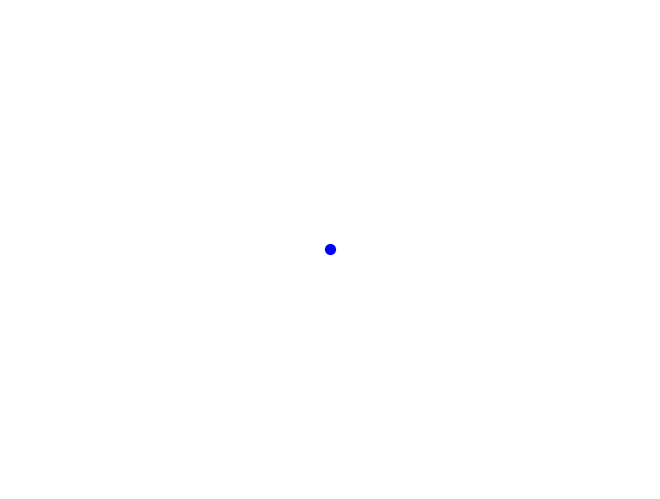

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 15 16:51:20 2024

@author: JNI
"""

import numpy as np
from pyomo.environ import *
import highspy as hp
import pandas as pd
import plotly
import plotly.express as px
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import time


"""
Region class:
~~~~~~~~~~~~
    
    Class objects are regions, which have a natural tree-structure. Each region
    can have a parent region and child regions (subregions), a data object, and 
    a set of hubs.
  
    class variables:
    ~~~~~~~~~~~~  
    
    self.name = str of the regions name (from data file input)
    self.parent = pointer to the parent region object
    self.childrem = dict of subregions, with name:object format
    self.data = data object, which should contain region-specific parameters
    self.grid = the grid the region lies in (inherited from parent region)
    self.depth = distance from root of tree
    
    class methods:
    ~~~~~~~~~~~~  
    
    display_children - prints a list of subregions
    display_hubs - prints a list of hubs in the region
    update_parent - changes the parent region (used in aggregation)
    create_subregion - creates a subregion with given name and data
    add_subregion - takes an existing region as an arg and assigns it as a subregion
    remove_subregion - removes a subregion from list of subregions
    add_hub - adds an existing hub to region hubs
    remove_hub - removes a hub from region hubs
    delete - deletes the region. hubs and subregions are reassigned to parent
    absorb_subregions -  aggregates subregion data into region's data, then deletes them, 
                         inherits their subregions and hubs
    absorb_subregions_deep - recursively runs absorb_subregions on subregions, 
                             their subregions etc so that region is the bottom level
    update_data - replaces data object with arg
    aggregate_subregion_data - takes all subregions, and aggregates their data
                               based on whether they are summable or meanable 
    get_data - pass the name of a parameter in data as arg, and receive the value.
    
"""


class Region:
    
    def __init__(self, name, grid = None, kind = None, data = None, parent=None):
        
        self.name = name
        self.parent = parent
        self.children = {}
        self.hubs = {}
        self.data = data
        
        if self.parent != None: 
            self.depth = self.parent.depth + 1 
            self.grid = parent.grid
            
        else: 
            self.depth = 0
            self.grid = grid
 

        
    def display_children(self):
        for child in self.children.values():
            print(child.name, child.depth)
            child.display_children()
       
        
    def display_hubs(self):
        
        for hub in self.hubs.values():
            print(hub.name)
        
    def update_parent(self, new_parent):
        
        if self.parent != None:
            del self.parent.children[self.name]
            self.parent = new_parent
            self.parent.add_subregion(self)
            self.depth = new_parent.depth + 1
            
        else: 
            self.parent = new_parent
            self.parent.add_subregion(self)
    
    def create_subregion(self,name, data = None):
        
        self.grid.create_region(name,self,data)

    def add_subregion(self,subregion):
        
        self.children.update({subregion.name:subregion})
        
    def remove_subregion(self,subregion):
        self.children.pop(subregion.name)       
    
    def add_hub(self, hub):
        self.hubs.update({hub.name:hub})
        
    def remove_hub(self,hub):
        del self.hubs[hub.name]
        
    def delete(self):
        
        for hub in self.hubs.values():
            hub.change_region(self.parent)
            
        for child in list(self.children.values()):
            child.update_parent(self.parent)
            self.parent.add_subregion(child)
        
        if self.name in self.parent.children.keys():
            self.parent.remove_subregion(self)
        
        
        
    def absorb_subregions(self):
        
        subregions = list(self.children.values())
        
        if self.data is None: self.aggregate_subregion_data(subregions)
        
        
        for subregion in subregions:
            self.grid.delete(subregion)
            
        del subregions
    
    def absorb_subregions_deep(self):
        
        subregions = list(self.children.values())
        #print([subregion.name for subregion in subregions])
        
        for subregion in subregions:
            #print(subregion.name)
            
            subregion.absorb_subregions_deep()
            
            print("deleting: ", subregion.name)
            
            if self.data is None: self.aggregate_subregion_data(subregions)
            self.grid.delete(subregion)
            
        del subregions
    
    def update_data(self,df):
        self.data = df

    def aggregate_subregion_data(self,subregions):
        
        temp_child_data = pd.concat([region.data for region in subregions], axis = 1).transpose()
        #print(temp_child_data)
        new_data = pd.DataFrame(columns= self.grid.data.summable['region'] + self.grid.data.meanable['region'])
        
        for column in temp_child_data.columns:
            if column in self.grid.data.summable['region']: new_data[column] = [temp_child_data[column].sum()]
            if column in self.grid.data.meanable['region']: new_data[column] = [temp_child_data[column].mean()]
        
        self.update_data(new_data.squeeze())
        
    def get_data(self,quantity):
        
        if self.data is None: return 0
        else: return self.data[quantity]
             
        
'''
HUB CLASS
~~~~~~~~~

class objects are individual hubs, which are fundamental units of production in
the model. Hubs belong to regions, and connect to each other with transportation
arcs.

    class variables:
    ~~~~~~~~~~~~~~~
    
    name - str name of hub (from input data or aggregated)
    region - region located in
    data - data object that stores hub-specific parameters
    outbound - dict of arcs outbound from hub, with destination hub name:destination hub object format
    inbound - dict of arcs inbound to hub, with origin hub name: origin hub object format
    x,y - location coordinates (will deprecate)
    
    class methods:
    ~~~~~~~~~~~~~
    
    change_region - region arg becomes hub's region and hub is added to args hublist
    display_outbound - print outbound arcs
    display_inbound - print inbound arcs
    add_outbound - add arc arg as an outbound arc
    add_inbound - add arc arg as an inbound arc
    remove_outbound - remove an outbound arc
    remove_inbound - remove an inbound arc
    get_data - pass the name of a parameter in data as arg, and receive the value.
    cost - temp cost function, to be deprecated
'''
        
class Hub:
    
    
    
    def __init__(self,name,region,data=None):
        
        self.name = name
        self.region = region
        self.data = data.fillna(0)
        
        # outbound and inbound dictionaries mapping names of hubs to the arc objects
        self.outbound = {}
        self.inbound = {}
        
        self.x = data.iloc[0]['x']
        self.y = data.iloc[0]['y']

    
    def change_region(self,new_region):
        self.region = new_region
        new_region.add_hub(self)
        
    
    def display_outbound(self):
        for arc in self.outbound.values():
            print("name:",arc.origin.name,"capacity:",arc.capacity)
               
     
    '''
    Add and remove arc functions
    
    only modifies itself
    '''    
    def add_outbound(self,arc):
        
        self.outbound[arc.destination.name] = arc
    
    def add_inbound(self,arc):
        
        self.inbound[arc.origin.name] = arc
            
    def remove_outbound(self,arc):
        
        del self.outbound[arc.destination.name]
    
    def remove_inbound(self,arc):
        
        del self.inbound[arc.origin.name]
    
    
    def get_data(self,quantity):
        
        return self.data.iloc[0][quantity]
        
    def cost(self,technology,year):
        
        
        
        
        if technology == 'PEM': return self.region.data['electricity_cost']*45
        elif technology == 'SMR': return self.region.data['gas_cost'] 
        else: return 0 
        
        
'''
TRANSPORTATION ARC CLASS
~~~~~~~~~~~~~~~~~~~~~~~~
    
    objects in this class represent individual transportation arcs. An arc can
    exist with zero capacity, so they only represent *possible* arcs.
    
    class variables:
    ~~~~~~~~~~~~~~~
    
    name - the name used by the registry. Unlike regions and hubs, arc names are
           fully determined. They are tuples of origin hub name and dest hub name.
    origin - pointer to origin hub object
    destination - pointer to destination hub object
    capacity - base capacity
    cost - generic cost parameter (to be deprecated)
    
    class methods:
    ~~~~~~~~~~~~~
    
    change_origin - changes the origin hub and name to reflect that
    chage_destination - changes the destination hub and name to reflect that
    disconnect - removes itself from the inbound and outbound hubs' arc lists.
    
'''
        
        
        
        
        
class TransportationArc:
    
    
    def __init__(self,origin, destination, capacity,cost = 0):
        
        
        self.name = (origin.name,destination.name)
        self.origin = origin
        self.destination = destination
        self.capacity = capacity
        self.cost = cost
        
    def change_origin(self,new_origin):
        
        self.name = (new_origin.name,self.name[1])
        self.origin = new_origin
    
    def change_destination(self,new_destination):
        self.name = (self.name[0],new_destination.name)
        self.destination = new_destination

    def disconnect(self):
        
        self.origin.remove_outbound(self)
        self.destination.remove_inbound(self)
        
     
        
'''
REGISTRY CLASS
~~~~~~~~~~~~~~
     
    This class is the central registry of all objects in a grid. It preserves them 
    in dicts of object-name:object so that they can be looked up by name.
    it also should serve as a place to save data in different configurations for
    faster parsing - for example, depth is a dict that organizes regions according to
    their depth in the region nesting tree.
    
    class variables:
    ~~~~~~~~~~~~~~~
    
    regions - dict of region name:region object
    hubs - dict of hub name:hub object
    arcs - dict of arc name:arc object
    depth - dict of ints and lists of regions with int n:list of regions at that depth
    max_depth - the max depth in the tree
    
    
    class methods:
    ~~~~~~~~~~~~~
     
    add - generic method to add something to the registry. Depending on the type
          thing, it adds it to the appropriate variable and adjusts others as necessary
    remove - generic method to remove something from the registry. Depending on the 
             type of thing, it removes it from the appropriate variable and adjusts
             others as necessary.
    update_levels - updates the level counts (such as when you aggregate and a region
                    changes level)
    
    
'''
        
class Registry:
    
    def __init__(self):
        self.regions = {}
        self.depth = {i:[] for i in range(10)}
        self.hubs = {}
        self.arcs = {}
        self.max_depth = 0
        
        
    def add(self,thing):
        
        if type(thing) == Hub:
            self.hubs[thing.name] = thing
            return thing
        elif type(thing) == TransportationArc:
            self.arcs[thing.name] = thing
            return thing
        elif type(thing) == Region:
            self.regions[thing.name] = thing
            self.depth[thing.depth].append(thing.name)
            if thing.depth > self.max_depth: self.max_depth = thing.depth
            return thing
        
    def remove(self,thing):
        
        if type(thing) == Hub:
            del self.hubs[thing.name]
        elif type(thing) == Region:
            #self.depth[thing.depth] = self.depth[thing.depth].remove(thing.name)
            del self.regions[thing.name]
            
        elif type(thing) == TransportationArc:
            del self.arcs[thing.name]
            
    def update_levels(self):
        
        self.depth = {i:[] for i in range(10)}
        for region in self.regions.values():
            self.depth[region.depth].append(region.name)
        pass
        
'''
GRID CLASS
~~~~~~~~~~~

    This is the central class that binds all the other classes together. No class
    instance exists in a reference that isn't fundamentally contained in a grid.
    The grid is used to instantiate a model, read data, create the regionality
    and hub / arc network within that regionality, assign data to objects and more.
    
    notably, the grid is used to coordinate internal methods in various classes to 
    make sure that their combined actions keep the model consistent and accomplish
    the desired task.
    
    class variables:
    ~~~~~~~~~~~~~~~
    
    data = this is a data object 
    
    class methods:
    ~~~~~~~~~~~~~
    
    
'''        
class Grid:
    
    def __init__(self, data = None):
        
        if data != None:
            self.data = data
            
            
            
    def visualize(self):
        
        
        G = nx.DiGraph()
        positions = {}
        for hub in self.registry.hubs.values():
            if hub.region.depth == 1:
                color = 'green'
                size = 100
            elif hub.region.depth == 2: 
                color = 'red'
                size = 50
                
            else: 
                color = 'blue'
                size = 30
                
            G.add_node(hub.name, pos = (hub.x,hub.y), color = color)
            positions[hub.name] = (hub.x,hub.y)
        edges = [arc for arc in self.registry.arcs.keys()]
        
        G.add_edges_from(edges)

        node_colors = [G.nodes[data]['color'] for data in G.nodes()]

        nx.draw(G, positions, with_labels = False, node_size = 50, node_color = node_colors)
        plt.show()

    """
    Creation methods for region, hub, and arc.
    
    All classes should refer to these methods when creating instances so that everything
    is centralized. The methods will have return values so they can also be accessed during creation
    within their class. In some cases, the natural procedure should be to initiate the creation within
    another instance of the class so that the return value can be taken advantage of.
    
    
    """


    def create_region(self,name,parent = None, data = None):
        
        if parent == None:         
            return self.registry.add_region(Region(name,parent = parent,grid = self,data = data))
        else:
            parent.add_subregion((self.registry.add(Region(name,parent = parent,grid = self,data = data))))
            
    def create_arc(self,origin,destination,capacity, cost = 0):
        
        self.registry.add(TransportationArc(origin, destination, capacity,cost))
        origin.add_outbound(self.registry.arcs[(origin.name,destination.name)])
        destination.add_inbound(self.registry.arcs[(origin.name,destination.name)])
    
    def create_hub(self, name, region, data = None):
        
        
        region.add_hub(self.registry.add(Hub(name,region,data)))
        
    '''
    delete function (works on arcs, hubs, and regions)
    '''    
    
    def delete(self,thing):
        
        if type(thing) == Region:
            
            thing.delete()
            self.registry.remove(thing)
            
        if type(thing) == Hub:
            
            for arc in list(thing.outbound.values()):
                self.delete(arc)   
            for arc in list(thing.inbound.values()):
                self.delete(arc)
            
            thing.region.remove_hub(thing)
            self.registry.remove(thing)
            
        if type(thing) == TransportationArc:
            
            thing.disconnect()
            self.registry.remove(thing)
    
    
    def build_grid(self):
        
        self.registry = Registry()
        self.world = Region('world', grid = self, data = self.data.regions)
        
        
        self.recursive_region_generation(self.data.regions,self.world)
        self.load_hubs()
        self.arc_generation(self.data.arcs)
        
        self.visualize()
        
    def recursive_region_generation(self,df, parent):

        if df.columns[0] == 'data':
            for index, row in df.iterrows():
                #print(row[1:])
                parent.update_data(row[1:])
                
                '''
                if type(row.hub) == str: 
                    self.create_hub(row.hub, parent,self.data.hubs.loc[self.data.hubs.hub == row.hub][self.data.hubs.columns[1:]])
                    parent.update_data(df[df.columns[1:]])
                '''
        else: 
            
            
            for region in df.iloc[:,0].unique():
                if type(region) == str and region != 'None':
                    #print(df.columns[0]+':',region)
                    parent.create_subregion(region)
                    self.recursive_region_generation(df[df[df.columns[0]] == region][df.columns[1:]], parent.children[region])
                elif region == 'None':
                    
                    self.recursive_region_generation(df[df[df.columns[0]].isna()][df.columns[1:]], parent)
                
                else:
                    
                    self.recursive_region_generation(df[df[df.columns[0]].isna()][df.columns[1:]], parent)


    def arc_generation(self,df):
        
        for index, row in df.iterrows():
            
            self.create_arc(self.registry.hubs[row.origin],self.registry.hubs[row.destination],row['capacity'])
            #self.registry.add(TransportationArc(self.registry.hubs[row.origin],self.registry.hubs[row.destination],row['capacity']))
            #self.registry.hubs[row.origin].add_outbound(self.registry.arcs[(row.origin,row.destination)])
            #self.registry.hubs[row.destination].add_inbound(self.registry.arcs[(row.origin,row.destination)])
    
    def connect_subregions(self):
        
        for hub in self.registry.hubs.values():
            
            if hub.region.children == {}:
                
                for parent_hub in hub.region.parent.hubs.values():
                    
                    self.create_arc(hub, parent_hub, 10000000)
    

    def load_hubs(self):
        
        for index, row in self.data.hubs.iterrows():
            
            #print(row['hub'], row['region'])
            #print(row[2:], type(row[2:]))
            self.create_hub(row['hub'], grid.registry.regions[row['region']], data = pd.DataFrame(row[2:]).transpose().reset_index())
            
            
    
    def aggregate_hubs(self,hublist,region):
        
        
        
        temp_hub_data = pd.concat([hub.data for hub in hublist])  
        new_data = pd.DataFrame(columns= self.data.summable['hub'] + self.data.meanable['hub'])
        
        for column in temp_hub_data.columns:
            if column in self.data.summable['hub']: new_data[column] = [temp_hub_data[column].sum()]
            if column in self.data.meanable['hub']: new_data[column] = [temp_hub_data[column].mean()]
        
        name = '_'.join([hub.name for hub in hublist])
        self.create_hub(name,region,new_data)
        
        inbound = {}
        outbound = {}
        
        for hub in hublist:
            for arc in hub.inbound.values():
                if arc.origin not in hublist:
                    if arc.origin.name not in inbound.keys(): inbound[arc.origin.name] = [arc]
                    else: inbound[arc.origin.name].append(arc)
            for arc in hub.outbound.values():
                if arc.destination not in hublist:
                    if arc.destination.name not in outbound.keys(): outbound[arc.destination.name] = [arc]
                    else: outbound[arc.destination.name].append(arc)
            
        for origin in list(inbound.keys()):
            self.combine_arcs(inbound[origin],self.registry.hubs[origin],self.registry.hubs[name])
        for destination in list(outbound.keys()):
            self.combine_arcs(outbound[destination],self.registry.hubs[name],self.registry.hubs[destination])
        
        del inbound
        del outbound
        
        for hub in hublist:
            self.delete(hub)
        
        del hublist                        
            
    def combine_arcs(self,arclist,origin,destination):
            
        capacity = sum([arc.capacity for arc in arclist])
        cost = sum([arc.cost*arc.capacity for arc in arclist])/capacity
            
        self.create_arc(origin, destination, capacity,cost)
        
        for arc in arclist: self.delete(arc)
                
    def write_data(self):
        
        hublist = [hub for hub in list(self.registry.hubs.values())]
        hubdata = pd.concat([pd.DataFrame({'hub':[hub.name for hub in hublist]}),pd.concat([hub.data for hub in hublist]).reset_index()], axis = 1)
        hubdata.to_csv('saveddata.csv', index = False)
        
        regionlist = [region for region in list(self.registry.regions.values()) if not region.data is None]
        regiondata = pd.concat(  [pd.DataFrame(  {'region':[region.name for region in regionlist]} ),pd.concat([region.data for region in regionlist], axis = 1).transpose().reset_index()] , axis = 1)
        regiondata = regiondata[['region'] + self.data.summable['region'] + self.data.meanable['region']]
        regiondata.to_csv('regiondatasave.csv', index= False)
        
        arclist = [arc for arc in list(self.registry.arcs.values())]
        arcdata = pd.DataFrame({'origin':[arc.origin.name for arc in arclist], 'destination': [arc.destination.name for arc in arclist], 'capacity': [arc.capacity for arc in arclist], 'cost': [arc.cost for arc in arclist]})
        arcdata.to_csv('arcdatasave.csv',index = False)
        
    
    def collapse(self,region_name):
        
        self.registry.regions[region_name].absorb_subregions_deep()
        self.aggregate_hubs(list(self.registry.regions[region_name].hubs.values()),self.registry.regions[region_name])
        self.registry.update_levels()
        self.visualize()        
    

    def build_model(self, mode = 'standard'):
        
        self.model = Model(self, mode)
        
    def test(self):
        
        #start = time.time()
        
        self.build_model()
        self.model.start_build()
        #self.model.solve(self.model.m)

        #end = time.time()
        
        #print(end - start)
        
    def collapse_level(self,level):
        for region in self.registry.depth[level]: self.collapse(region)


class Data:
    
    def __init__(self):
        
        self.regions = pd.read_csv('regions_single_test.csv', index_col = False)
        self.hubs = pd.read_csv('hubs_single_region.csv', index_col = False)
        self.arcs = pd.read_csv('transportation_arcs_single_region.csv', index_col = False)
        
        #self.regions = pd.read_csv('regions.csv', index_col = False)
        #self.hubs = pd.read_csv('hubs.csv', index_col = False)
        #self.arcs = pd.read_csv('transportation_arcs.csv', index_col = False)
        
        params = pd.ExcelFile('parameter_list.xlsx')
        
        self.hub_params = pd.read_excel(params,'hub', index_col = False)
        self.region_params = pd.read_excel(params,'region', index_col = False)
        self.arc_params = pd.read_excel(params, 'arc', index_col = False)
        self.global_params = pd.read_excel(params,'global', index_col = False)
        self.technologies = [column_name.split('_')[2] for column_name in self.hubs.columns if column_name.lower().startswith('production_capacity')]
        #self.technologies = [self.hubs[hub].data.iloc[0]['H2Capacity_' + tech] for hub in m.hubs for tech in m.technology]
        
        self.summable = {'hub': self.hub_params[self.hub_params['aggregation_type'] == 'sum']['parameter'].tolist(), 'region': self.region_params[self.region_params['aggregation_type'] == 'sum']['parameter'].tolist(),'arc':self.arc_params[self.arc_params['aggregation_type'] == 'sum']['parameter'].tolist()}
        self.meanable = {'hub': self.hub_params[self.hub_params['aggregation_type'] == 'mean']['parameter'].tolist(), 'region': self.region_params[self.region_params['aggregation_type'] == 'mean']['parameter'].tolist(),'arc':self.arc_params[self.arc_params['aggregation_type'] == 'mean']['parameter'].tolist()}
    
        self.fixed_production_cost = {}
        #OM_production_cost = {}
        
        for technology in self.technologies:
            self.fixed_production_cost[technology] = self.global_params.loc[self.global_params.parameter == 'fixed_cost_' + technology].reset_index()['default_value'][0]
                
    
    
    def updata_data():
        pass





class Functions:
    
    def __init__(self,model, mode = 'standard', start_year = 2025, end_year = 2026):
        
        self.grid = model.grid
        self.registry = model.registry
        self.data = model.data
        self.mode = mode
        self.start_year = start_year
        self.end_year = end_year
        self.model = model
        
        if self.mode == 'standard':
            
            self.time = 'annual'
            
    def get_electricty_consumption(self,m,region,year):
        
        return sum(m.electricity_consumption_rate[tech]*value(m.h2_volume[hub,tech,year]) for tech in m.technology for hub in self.model.regions[region].hubs.keys())
        
        
    def get_capacity(self, hub, tech):
        
        if self.mode == 'standard':
            
            return self.registry.hubs[hub].get_data('production_capacity_' + tech)
    def get_electricity_consumption_rate(self,tech):
        
        rates = {'PEM':54.3, 'SMR':5.1}
        
        return rates[tech]
    def get_production_cost(self,hub,tech,year,m, update = False):   
        

        if self.mode == 'standard':
            
            if tech == 'PEM': return m.electricity_price[self.registry.hubs[hub].region.name,year]*m.electricity_consumption_rate[tech]
            elif tech == 'SMR': return m.gas_price[self.registry.hubs[hub].region.name,year] + m.electricity_price[self.registry.hubs[hub].region.name,year]*m.electricity_consumption_rate[tech]
            else: return 0
            
        elif self.mode == 'integrated':
            
            if tech == 'PEM': return self.get_elec_price(hub,year)*self.model.electricity_consumption_rate[tech]
        elif tech == 'SMR': return self.registry.hubs[hub].get_data('gas_cost')
        
    def get_elec_price(self,region,year,m):
        
        if self.mode == 'standard': 
            if self.registry.regions[region].data is None:
                return 0
            else: return self.registry.regions[region].get_data('electricity_cost')
        
        elif self.mode == 'integrated': 
            return self.registry.regions[region].get_data('electricity_cost')
                                                
    
    def get_gas_price(self, region, year):
        
        if self.registry.regions[region].data is None:
            return 0
        
        else: return self.registry.regions[region].get_data('gas_cost')
        
    def get_demand(self, region, time):
        
        
        
        if self.mode == 'standard':
            
            if self.registry.regions[region].data is None:
                return 0
            else:
                return self.registry.regions[region].get_data('demand')*1.05**(time - self.start_year)
        
        elif self.mode == 'integrated':
            
            return self.model.demand[region,time]
            
        
        return 0
    
    
    
    def objective(self):
        pass
        
    
    
    def constraints(self):
        pass
    
    
        
        
from datetime import datetime
import pandas as pd
import pyomo.environ as pyo
import gc
import highspy
from pyomo.common.timing import TicTocTimer       
        


def ECMModel2a(H2var, sense=pyo.minimize, as_block=False):
    
    def __init__(self,grid, mode):
        
        self.grid = grid
        self.registry = grid.registry
        self.hubs = grid.registry.hubs
        self.regions = grid.registry.regions
        self.arcs = grid.registry.arcs
        self.data = grid.data
        self.functions = Functions(self,mode)
        
        
        
    def start_build(self):
        
        self.m = ConcreteModel()
        self.m.dual = Suffix(direction=Suffix.IMPORT)
        self.generate_sets(self.m)
        self.generate_parameters(self.m)
        self.generate_variables(self.m)
        self.generate_constraints(self.m)
        
        self.m.production_cost = Objective(rule = self.total_cost(self.m))
    
    def generate_sets(self,m):
        
        m.hubs = Set(initialize = self.hubs.keys())
        m.arcs = Set(initialize = self.arcs.keys())
        m.regions = Set(initialize = self.regions.keys())
        m.technology = Set(initialize = self.data.technologies)
        m.year = RangeSet(self.functions.start_year, self.functions.end_year)
        
        
    def generate_parameters(self,m):
        
        #m.cost = Param(m.hubs,m.technology,m.year, initialize = {(hub, tech, year): self.hubs[hub].cost(tech, year) for hub in m.hubs for tech in m.technology for year in m.year})
        
        m.capacity = Param(m.hubs,m.technology, initialize = {(hub, tech): self.functions.get_capacity(hub,tech) for hub in m.hubs for tech in m.technology})
        m.electricity_consumption_rate = Param(m.technology, initialize = {tech:self.functions.get_electricity_consumption_rate(tech) for tech in m.technology})
        m.gas_price = Param(m.regions,m.year,initialize = {(region,year):self.regions[region].get_data('gas_cost') for region in m.regions for year in m.year})
        # mutables:
            
        m.demand = Param(m.regions,m.year, mutable=True, initialize = {(region,year): self.functions.get_demand(region,year) for region in m.regions for year in m.year})
        m.electricity_price = Param(m.regions,m.year, mutable = True, initialize = {(region,year): self.functions.get_elec_price(region,year,m) for region in m.regions for year in m.year})
        m.cost = Param(m.hubs,m.technology,m.year, mutable=True, initialize = {(hub, tech, year): self.functions.get_production_cost(hub,tech,year,m) for hub in m.hubs for tech in m.technology for year in m.year})

    def generate_variables(self,m):
        
        m.h2_volume = Var(m.hubs,m.technology,m.year,within = NonNegativeReals)
        m.transportation_volume = Var(m.arcs,m.year, within = NonNegativeReals)
        m.capacity_expansion = Var(m.hubs,m.technology,m.year, within = NonNegativeReals, initialize=0.0)
        m.trans_capacity_expansion = Var(m.arcs,m.year,within = NonNegativeReals, initialize = 0.0)
        
        
    def generate_constraints(self,m):
        
        m.capacity_constraint = Constraint(m.hubs,m.technology,m.year, rule = self.capacity_constraint)
        m.transportation_constraint = Constraint(m.arcs,m.year, rule = self.transportation_capacity_constraint)
        m.demand_constraint = Constraint(m.regions,m.year, rule = self.demand_constraint)
        
    
    def mass_balance(self,m,hub,year):
        
        return sum(m.h2_volume[hub,tech,year] for tech in m.technology) + sum(m.transportation_volume[arc.name,year] 
               for arc in self.hubs[hub].inbound.values()) - sum(m.transportation_volume[arc.name,year] for arc in 
                                                                 self.hubs[hub].outbound.values())
    

    def transportation_capacity_constraint(self,m,origin,destination, year):
        
        return m.transportation_volume[(origin,destination),year] <= self.arcs[(origin,destination)].capacity + sum(m.trans_capacity_expansion[(origin,destination),year] for year in range(m.year[1],year) )
        #return m.transportation_volume[(origin,destination),year] <= self.arcs[(origin,destination)].capacity
        
        
    
    def capacity_constraint(self,m,hub,tech,year):
        
        #return m.h2_volume[hub,tech,year] <= self.hubs[hub].data.iloc[0]['H2Capacity_' + tech] + m.capacity_expansion[hub,tech, year]
        return m.h2_volume[hub,tech,year] <= self.functions.get_capacity(hub, tech) + sum(m.capacity_expansion[hub,tech,year] for year in range(max(m.year[1],year-30),year))
        

    def demand_constraint(self,m,region,year):
        
        if len(self.regions[region].hubs) == 0: 
            return Constraint.Feasible
        else: 
            return sum(self.mass_balance(m,hub,year) for hub in self.regions[region].hubs.keys()) == m.demand[region,year]
                

    
    def production_cost(self, m):
        
        return sum(m.h2_volume[hub,tech,year]*m.cost[hub,tech,year] for hub in m.hubs for tech in m.technology for year in m.year)
            
    def transportation_cost(self,m):
        
        return sum(m.transportation_volume[arc,year]*.12 for arc in m.arcs for year in m.year)
    
    def prod_capacity_expansion_cost(self,m):
        
        return sum(m.capacity_expansion[hub,tech,year]*10 for hub in m.hubs for tech in m.technology for year in m.year)
    
    def trans_capacity_expansion_cost(self,m):
        
        return sum(m.trans_capacity_expansion[arc,year]*3 for arc in m.arcs for year in m.year)
    
    def capacity_expansion_cost(self,m):
        
        return self.prod_capacity_expansion_cost(m) + self.trans_capacity_expansion_cost(m)
    
    def solve(self, m):
        
        solver = SolverFactory('appsi_highs')
        solver.solve(m,tee=True).write()

        self.production_stats = pd.DataFrame({'region':[region for region in m.regions for tech in m.technology for year in m.year ], 'technology': [tech for region in m.regions for tech in m.technology for year in m.year],'year': [year for region in m.regions for tech in m.technology for year in m.year] , 'volume':[sum(value(m.h2_volume[hub,tech,year]) for hub in self.regions[region].hubs.keys()) for region in m.regions for tech in m.technology for year in m.year]})
        
        for tech in m.technology:
            self.production_stats['electricity_consumption_' + tech] = self.production_stats['volume']*m.electricity_consumption_rate[tech]
        
        #self.H2_price = np.array([(self.registry.hubs[hub].region.name,year, m.dual[m.demand_constraint[self.registry.hubs[hub].region.name,year]]) for hub in m.hubs for year in m.year])
        self.h2_price = pd.DataFrame({'region': [self.registry.hubs[hub].region.name for hub in m.hubs for year in m.year], 'year':[year for hub in m.hubs for year in m.year],'price':[m.dual[m.demand_constraint[self.registry.hubs[hub].region.name,year]] for hub in m.hubs for year in m.year]})
        
        
        '''
        ~~~~~~~~~
        
        relevant quantities:
            
            h2_price
            production_stats
        
        h2_price - a dataframe of h2_prices by region and year
        
        production_stats - a dataframe that shows h2_production quantities by region,
        technology, and year, along with the quantity of electricity consumed at
        each

        ~~~~~~~~~
        '''
        
        
    def total_cost(self,m):
        
        return self.production_cost(m) + self.transportation_cost(m) + self.capacity_expansion_cost(m) 
    
        

    def update_demand(self, new_demand):        
        
        '''
        insert new demand as a dict in the format: new_demand[region,year]
        '''
        
        self.m.demand.store_values(new_demand)
        #new_demand = {(region,year): self.m.demand[region,year].value*1.1 for region in self.m.regions for year in self.m.year}
        
    def update_electricity_price(self,new_electricity_price):
        
        #new_electricity_price = {(region,year): self.m.electricity_price[region,year]*1.1 for region in self.m.regions for year in self.m.year}
        
        self.m.electricity_price.store_values(new_electricity_price)

    def update_exchange_params(self, new_demand,new_electricity_price):
        
        #self.update_demand({(region,year): self.m.demand[region,year].value*1.1 for region in self.m.regions for year in self.m.year})
        #self.update_electricity_price()
        
        self.update_demand(new_demand)
        self.update_electricity_price(new_electricity_price)
        self.m.cost.store_values({(hub, tech, year): self.functions.get_production_cost(hub,tech,year,self.m) for hub in self.m.hubs for tech in self.m.technology for year in self.m.year})

    def resolve(self,new_demand,new_electricity_price):
        
        """
        For convenience: After building and solving the model initially:
        
        new_demand: dict - new_demand[region,year] for H2demand in (region,year)
        new_electricity_price: dict - new_electricity_price[region,year]
        
        
        then you can access the price duals and the quantities of electricity
        consumption as described in the comments in the solve() method
        """
        
        
        self.update_exchange_params(new_demand,new_electricity_price)
        self.solve(self.m)
        
        

def visualize_regions(data):

    data.fillna("None",inplace = True)
    data['all'] = 'world'

    fig = px.treemap(data_frame = data, path = ['all'] + [name for name in data.columns if name.lower().endswith('region')], values = 'H2Capacity')
    fig.write_html('regions.html', auto_open=True)
    
grid = Grid(Data())
grid.build_grid()
# supply->hub->demand distribution model


In [5]:
h1 = ECMModel2a(0, sense=pyo.minimize, as_block=False)
SolverFactory("appsi_highs").solve(h1)

AttributeError: 'NoneType' object has no attribute 'component_objects'